In [ ]:
import multiprocessing 

import six
import numpy as np
import tensorflow.compat.v2 as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

!pip install git+https://github.com/google/qkeras

  Cloning https://github.com/google/qkeras to /tmp/pip-req-build-gpq6xanh
  Running command git clone -q https://github.com/google/qkeras /tmp/pip-req-build-gpq6xanh
     |████████████████████████████████| 174kB 9.1MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 22.2MB 1.5MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
  Created wheel for QKeras: filename=QKeras-0.8.0-cp36-none-any.whl size=148269 sha256=564d9392a32d3c4c329ebebbe688d150ae4279217f8c97cc616f9fc4408b3566
  Stored in directory: /tmp/pip-ephem-wheel-cache-4piifra_/wheels/b4/74/1d/9456d62789716894a5edd7e342b4beaef69241ac584706c68d
  Created wheel for pyparser: filename=pyparser-1.0-cp36-none-any.whl size=4944 sha256=a30d4a2fd0b4c83b6e274a5ef6ef9465727b1187a0fe1ce2332c03900c9a50db
  Stored in directory: /root/.cache/pip/wheels/8a/1c/4f/9f66cd69719aa41c2684efae758d95db7803e9fe1f65146db1
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape + (1,)).astype("float32")
    x_test = x_test.reshape(x_test.shape + (1,)).astype("float32")

    x_train /= 256.0
    x_test /= 256.0

    x_mean = np.mean(x_train, axis=0)

    x_train -= x_mean
    x_test -= x_mean

    nb_classes = np.max(y_train)+1
    y_train = to_categorical(y_train, nb_classes)
    y_test = to_categorical(y_test, nb_classes)

    quantizer = quantized_bits(9, 1)
    x_train = quantizer(x_train)
    x_test = quantizer(x_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = get_data()

# **Now for CIFAR 10**

In [ ]:
from tensorflow.keras.datasets import cifar10

def get_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #x_train, x_test = tf.image.rgb_to_grayscale(x_train).numpy(), tf.image.rgb_to_grayscale(x_test).numpy()
    x_train = np.average(x_train, axis=3, weights=[0.2125, 0.7154, 0.0721]) 
    x_test = np.average(x_test, axis=3, weights=[0.2125, 0.7154, 0.0721])
    #cv2_imshow(x_train[4])
    x_train = x_train.reshape(x_train.shape + (1,)).astype("float32")
    x_test = x_test.reshape(x_test.shape + (1,)).astype("float32")

    print (np.max(x_train), np.max(x_test))
    x_train /= 256.0
    x_test /= 256.0

    x_mean = np.mean(x_train, axis=0)

    x_train -= x_mean
    x_test -= x_mean

    nb_classes = np.max(y_train)+1
    y_train = to_categorical(y_train, nb_classes)
    y_test = to_categorical(y_test, nb_classes)

    #quantizer = quantized_bits(9, 1)
    #x_train = quantizer(x_train)
    #x_test = quantizer(x_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = get_data()
print (x_train.shape)

170500096/170498071 [==============================] - 3s 0us/step
255.0 255.0
(50000, 32, 32, 1)


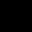

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

cv2_imshow(x_t[4])

In [ ]:
from qkeras import *
import qkeras
def CreateQModel(shape, nb_classes, intBits):
    x = x_in = Input(shape)

    x = Flatten(name="flatten")(x)
    x = QDense(256,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha = 1)".format(intBits),
        name="dense")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_1")(x)
    x = Activation('sigmoid')(x)
    x = QDense(128,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense2")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_2")(x)
    x = Activation('sigmoid')(x)
    x = QDense(128,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense3")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_3")(x)
    x = Activation('sigmoid')(x)
    x = QDense(nb_classes,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense4")(x)
    x = Activation("softmax", name="softmax")(x)


    model = Model(inputs=x_in, outputs=x)
    
    return model

# **Alternative Model Formation**

In [ ]:
def CreateQModel(shape, nb_classes, intBits):
    x = x_in = Input(shape)

    x = Flatten(name="flatten")(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    #x = Activation("softmax", name="softmax")(x)


    model = Model(inputs=x_in, outputs=x)
    
    return model

from tensorflow.keras.optimizers import Adam
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True)

model = CreateQModel(x_train.shape[1:], y_train.shape[-1], 1)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.0005),
    #optimizer='sgd',
    metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=30, batch_size=1024, validation_data=(x_test[:5000], y_test[:5000]), verbose=False) # callbacks=[callback])



In [ ]:
model.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 0s 1ms/step - loss: 1.9787 - accuracy: 0.3340


[1.9786514043807983, 0.33399999141693115]

In [ ]:
from qkeras.utils import *
from tensorflow.keras.optimizers import Adam
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)
qmodel = CreateQModel(x_train.shape[1:], y_train.shape[-1], 1)
qmodel.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.001),
    #optimizer='sgd',
    metrics=["accuracy"])
history = qmodel.fit(x_train, y_train, epochs=30, batch_size=25, validation_data=(x_test[:5000], y_test[:5000]), verbose=False, callbacks=[callback])
#history = qmodel.fit(x_train, y_train, epochs=40, batch_size=25, validation_data=(x_test[:5000], y_test[:5000]), verbose=False)
model_save_quantized_weights(qmodel)
print ("Done")

... quantizing model
Done


In [ ]:
history.history['val_accuracy']

[0.45339998602867126,
 0.46799999475479126,
 0.4790000021457672,
 0.4966000020503998,
 0.5055999755859375,
 0.503000020980835,
 0.5063999891281128,
 0.5135999917984009,
 0.5109999775886536,
 0.5099999904632568]

In [ ]:
qmodel.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 1s 4ms/step - loss: 1.6386 - accuracy: 0.4264


[1.6385540962219238, 0.42640000581741333]

In [ ]:
with open('/tmp/qmodelConfig.txt', 'w') as f:
  f.write(str(qmodel.get_config()))

In [ ]:
a = qmodel.get_weights()
print (len(a))

8


In [ ]:
from keras import backend as K
get_third_layer_output = K.function([qmodel.layers[0].input],
                                    [qmodel.layers[3].output])
layer3_output = get_third_layer_output([x_test])[0][5]


NameError: ignored

In [ ]:
len(layer3_output)

256

In [ ]:
np.mean(layer3_output)

-0.20086312

In [ ]:
np.std(layer3_output)

2.2948701

In [ ]:
layer3_output

In [ ]:
qmodel.get_config()

In [ ]:
qmodel.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 1s 4ms/step - loss: 0.0725 - accuracy: 0.9792


[0.07247753441333771, 0.979200005531311]

In [ ]:
wts = np.array(qmodel.get_weights())
print (type(wts))
#with open('/tmp/qmodelWeights2.txt', 'w') as f:
#  f.write(wts)

#qmodel.get_weights()

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
qmodel.save_weights('/tmp/qmodelWeightsVer4.txt')

In [ ]:
tangents = 2**(-1*np.arange(1.0, 100.0, 1.0))
lookup_arctanh = np.arctanh(tangents)

def cordicTanh(x, iterations):
  '''
  Returns the quantized tanh of the supplied argument x
  '''
  

  global  lookup_arctanh
  current_vector = np.array([1.2075, 0])
  z = x

  for i in range(1, iterations+1):
    m = -1
    sigma = np.sign(z)
    x = current_vector[0]
    y = current_vector[1]
    xnew = x
    ynew = y
    xnew = xnew - m*sigma*2**(-i)*y
    ynew = ynew + sigma*2**(-i)*x
    z = z - sigma*lookup_arctanh[i-1]
    current_vector = [xnew, ynew]

  
  ex = current_vector[0] + current_vector[1]
  eminusx = current_vector[0] - current_vector[1]

  temp1 = quantized_bits(9,1,alpha=1)(ex - eminusx)
  temp2 = quantized_bits(9, 1, alpha=1)(ex + eminusx)

  return quantized_bits(9,1, alpha=1)(temp1/temp2)

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool
justAHolder = 0
numOfIterations = 0

def calcAndStore(argument):
  global justAHolder
  i = argument[0]
  j = argument[1]
  justAHolder[i][j] = cordicTanh(justAHolder[i][j], numOfIterations)

def doit(arguments):
  if __name__ == '__main__':
    pool = ThreadPool(13)
    pool.map(calcAndStore, arguments)

In [ ]:
tangents = 2**(-1*np.arange(1.0, 100.0, 1.0))
lookup_arctanh = np.arctanh(tangents)

def modifiedCordicTanh(arr, iterations):
  '''
  Returns the quantized tanh of the supplied argument x
  '''
  xarr = 1.2075*np.ones(shape=(len(arr), len(arr[0])))
  yarr = np.zeros(shape = (len(arr), len(arr[0])))

  global  lookup_arctanh
  #current_vector = np.array([1.2075, 0])
  #z = x

  for i in range(1, iterations+1):
    m = -1
    sigma = np.sign(arr)
    
    xchange = m*sigma*2**(-i)*yarr
    ychange = sigma*2**(-i)*xarr
    arrchange = sigma*lookup_arctanh[i-1]

    xarr -= xchange
    yarr += ychange
    arr -= arrchange
    
    #x = current_vector[0]
    #y = current_vector[1]
    #xnew = x
    #ynew = y
    #xnew = xnew - m*sigma*2**(-i)*y
    #ynew = ynew + sigma*2**(-i)*x
    #z = z - sigma*lookup_arctanh[i-1]
    #current_vector = [xnew, ynew]

  ex = xarr + yarr
  #eminusx = xarr - yarr

  #temp1 = quantized_bits(9, 1, alpha=1)(ex - eminusx)
  #temp2 = quantized_bits(9, 1, alpha=1)(ex + eminusx)

  temp = quantized_bits(9, 1, alpha=1)(1 + ex)
  return quantized_bits(9,1, alpha=1)(ex/temp)

  #ex = current_vector[0] + current_vector[1]
  #eminusx = current_vector[0] - current_vector[1]

  #temp1 = quantized_bits(9,1,alpha=1)(ex - eminusx)
  #temp2 = quantized_bits(9, 1, alpha=1)(ex + eminusx)

  #return quantized_bits(9,1, alpha=1)(temp1/temp2)

In [ ]:
x_test = x_test[5000:]
y_test = y_test[5000:]

In [ ]:
def epicGeneratePredictions(indices, iterations):
  global justAHolder, numOfIterations
  from keras import backend as K
  get_third_layer_output = K.function([qmodel.layers[0].input],
                                    [qmodel.layers[2].output])
 
  layer3_output = get_third_layer_output([x_test])[0]

  layer3_output = layer3_output[indices[0]: indices[1]]

  layer3_output = modifiedCordicTanh(layer3_output, iterations)

  ### Let us try and sidestep this ###
  #for i in range(len(layer3_output)):
  #  for j in range(len(layer3_output[0])):
  #    layer3_output[i][j] = cordicSigmoid(layer3_output[i][j], iterations)

  #justAHolder = layer3_output
  #numOfIterations = iterations
  #arguments = np.dstack(np.meshgrid(np.array(range(len(layer3_output))), range(len(layer3_output[0])))).reshape(-1, 2)
  #doit(arguments)

  #layer3_output = justAHolder

  #print ("Done!!!")

  input_shape = qmodel.layers[4].get_input_shape_at(0)
  layer_input = Input(shape=(256))
  x = layer_input
  x = qmodel.layers[4](x)
  qm4 = Model(layer_input, x)

  predictions = qm4.predict(layer3_output)

  predictions = modifiedCordicTanh(predictions, iterations)

  #justAHolder = predictions
  #numOfIterations = iterations
  #arguments = np.dstack(np.meshgrid(np.array(range(len(predictions))), range(len(predictions[0])))).reshape(-1, 2)
  #doit(arguments)

  #predictions = justAHolder

  #for i in range(len(predictions)):
  #  for j in range(len(predictions[0])):
  #    predictions[i][j] = cordicSigmoid(predictions[i][j], iterations)

  input_shape = qmodel.layers[6].get_input_shape_at(0)
  layer_input = Input(shape=(128))
  x = layer_input
  x = qmodel.layers[6](x)
  qm4 = Model(layer_input, x)

  predictions = qm4.predict(predictions)


  predictions = modifiedCordicTanh(predictions, iterations)
  #justAHolder = predictions
  #numOfIterations = iterations
  #arguments = np.dstack(np.meshgrid(np.array(range(len(predictions))), range(len(predictions[0])))).reshape(-1, 2)
  #doit(arguments)

  #predictions = justAHolder

  #for i in range(len(predictions)):
  #  for j in range(len(predictions[0])):
  #    predictions[i][j] = cordicSigmoid(predictions[i][j], iterations)

  input_shape = qmodel.layers[8].get_input_shape_at(0)
  layer_input = Input(shape=(128))
  x = layer_input
  x = qmodel.layers[8](x)

  qm4 = Model(layer_input, x)
  predictions = np.array(qm4.predict(predictions))

  #answer = np.zeros_like(predictions)
  #answer[len(predictions), predictions.argmax()] = 1
  a = predictions
  return (a == a.max(axis=1)[:,None]).astype(int)
  #return answer

  #return answer




In [ ]:
answerVectors = []
for iter in [2,3,4, 5, 6, 7, 8, 9]:
  answerVectors.append(epicGeneratePredictions([0, 5000], iter))
  print ("Done")

Done
Done
Done
Done
Done
Done
Done
Done


In [ ]:
accuracy = []
for i in answerVectors:
  correct = 0
  for j in range(5000):
    if (i[j] == y_test[j]).all():
      correct += 1
  accuracy.append(correct)

accuracy

[1237, 1804, 1920, 1994, 2012, 2069, 2076, 2075]

In [ ]:
p, q = cifar10.load_data()

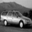

In [ ]:
meee = np.average(p[0], axis=3, weights=[0.2125, 0.7154, 0.0721])
#cv2_imshow(np.average(p[0][5], axis=2, weights=[0.2125, 0.7154, 0.0721]))
cv2_imshow(meee[4])

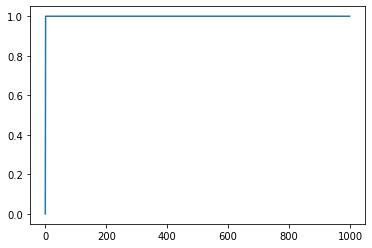

In [ ]:
#Experimenting with Bernoulli

toBePlotted = []
for i in np.arange(0, 10, 0.01):
  toBePlotted.append(binary_sigmoid(i))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(toBePlotted)

In [ ]:
max(np.abs(qmodel.get_weights()[0][4]))

0.1171875

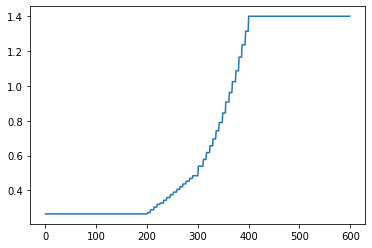

In [ ]:
toBePlotted = []
for i in np.arange(-3, 3, 0.01):
  toBePlotted.append(modifiedCordicTanh(np.array([[i, 0]]), 5)[0][0])

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(toBePlotted)